In [1]:
import os
os.chdir('<path to cloned git repository folder>/rapid-soh-estimation-from-short-pulses')

from rapid_soh_estimation.rapid_soh_estimation.config import *
from rapid_soh_estimation.rapid_soh_estimation.common_methods import *
from rapid_soh_estimation.rapid_soh_estimation.slowpulse import get_pulse_model_dataset
from rapid_soh_estimation.rapid_soh_estimation.cc_segment import get_cc_model_dataset

/opt/anaconda3/envs/envRapidSOH/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_color_scheme(cm_key:str):
    '''
    cm_key: must be one of the following [\'rocket\', \'ocean_thermal\', \'crest\', \'viridis\']
    returns (color_palette, model_color_idx)
    '''
    # color palettes contains a colormap, six main colors and subcolors each with three sub-tints
    cp_dic = {
        'rocket': {
            'cp':{
                'name':'rocket',
                'cm':None,      
                'colors':           ['#0F0B24', '#3F1B44', '#5D1E51', '#961B5B', '#CB1A4F', '#EB483D'],
                'cm_tints':None,
                'colors_lighter':   ['#5F5C6D', '#7F6782', '#93698B', '#B96792', '#DC668A', '#F2857E'],
                'colors_lightest':  ['#AFAEB6', '#BFB3C1', '#C9B4C5', '#DCB3C8', '#EEB3C4', '#F8C2BE'],
            },
            'model_color_idx': {'dummy':1, 'chg':3, 'dchg':4, 'both':5}
        },
        'ocean_thermal': {
            'cp':{
                'name':'ocean_thermal',
                'cm':None,      
                'colors':           ['#032335', '#313398', '#5D3D99', '#A55B85', '#E07160', '#FBAC3B'],
                'cm_tints':None,
                'colors_lighter':   ['#576C78', '#7677BA', '#937EBB', '#C392AE', '#EAA095', '#FCC87C'],
                'colors_lightest':  ['#ABB6BC', '#BABBDD', '#C9BEDD', '#E1C8D6', '#F5D0CA', '#FEE3BE'],
            },
            'model_color_idx': {'dummy':1, 'chg':2, 'dchg':3, 'both':4}
        },
        'ocean_thermal2': {
            'cp': {
                'name':'ocean_thermal2',
                'cm':None,      
                'colors':           ['#55616A', '#006183', '#00969F', '#90CEBA', '#EC941A', '#BA3E04'],
                'cm_tints':None,
                'colors_lighter':   ['#8C939A', '#6992AA', '#71B5BC', '#B4DDCE', '#F3B468', '#D17E58'],
                'colors_lightest':  ['#C3C7CB', '#B3C6D3', '#B8D7DB', '#D8ECE4', '#F9D7AD', '#E8BFAB'],
            },
            'model_color_idx': {'dummy':0, 'chg':2, 'dchg':3, 'both':4}
        },
        'ocean_thermal3': {
            'cp': {
                'name':'ocean_thermal3',
                'cm':None,      
                'colors':           ['#55616A', '#006B8A', '#00969F', '#90CEBA', '#EA9E25', '#D33627', '#A32A5D', '#401165'],
                'cm_tints':None,
                'colors_lighter':   ['#8C939A', '#6F9AB0', '#71B5BC', '#B4DDCE', '#F1BB6F', '#E17D61', '#BE758B', '#776293'],
                'colors_lightest':  ['#C3C7CB', '#B6CBD6', '#B8D7DB', '#D8ECE4', '#F8DAB2', '#EFBBA6', '#DDB9C2', '#B4AAC7'],
            },
            'model_color_idx': {'dummy':0, 'chg':2, 'dchg':3, 'both':4, 'cc':7}
        },
        'crest': {
            'cp': {
                'name':'crest',
                'cm':None,      
                'colors':           ['#2C3071', '#1F5985', '#287B8C', '#3F908E', '#63AC90', '#9BC890'],
                'cm_tints':None,
                'colors_lighter':   ['#7275A0', '#6A90AE', '#70A7B2', '#7FB5B4', '#97C8B5', '#BCDAB5'],
                'colors_lightest':  ['#B9BAD0', '#B4C8D6', '#B7D3D9', '#BFDAD9', '#CBE3DA', '#DEEDDA'],
            },
            'model_color_idx': {'dummy':0, 'chg':1, 'dchg':4, 'both':5}
        },
        'viridis': {
            'cp': {
                'name':'viridis',
                'cm':None,      
                'colors':           ['#401165', '#3B3B87', '#00839F', '#35B579', '#82C454', '#FEEA52'],
                'cm_tints':None,
                'colors_lighter':   ['#776293', '#7470A9', '#72A9BD', '#84CAA0', '#AAD58B', '#FEEE7B'],
                'colors_lightest':  ['#B4AAC7', '#B0AED0', '#B9D2DD', '#C0E1CB', '#D4E8C1', '#FFF6BD'],
            },
            'model_color_idx': {'dummy':1, 'cc':2, 'chg':3, 'dchg':4, 'both':5}
        },  
        'tab10_modified': {
            'cp': {
                'name':'tab10_modified',
                'cm':None,      
                'colors':           ['#817F7F', '#3182BD', '#F57E20', '#D62526',], # gray, blue, orange, red
                'cm_tints':None,
                'colors_lighter':   ['#9A9897', '#6C99CA', '#F89B53', '#DE654A',],
                'colors_lightest':  ['#B7B4B3', '#99B5D9', '#FBBA85', '#E79378',],
            },
            'model_color_idx': {'dummy':0, 'cc':1, 'chg':2, 'dchg':3, 'both':0, }
        },            
    }
    assert cm_key in cp_dic.keys()
    
    #region: create colormaps for selected color paletts
    color_palette = cp_dic[cm_key]['cp']
    color_palette['cm'] = mpl.colors.LinearSegmentedColormap.from_list(name=color_palette['name'], colors=color_palette['colors'], N=256)
    color_palette['cm_tints'] = []
    for i in range(0, len(color_palette['colors'])):
        color_palette['cm_tints'].append( mpl.colors.LinearSegmentedColormap.from_list(
            name=color_palette['name'], 
            colors=[ color_palette['colors'][i], color_palette['colors_lighter'][i], color_palette['colors_lightest'][i] ], 
            N=256) )
    #endregion

    return cp_dic[cm_key]['cp'], cp_dic[cm_key]['model_color_idx'], 

# set the global color palette to use & the idx of the color to use for each model type
color_palette, model_color_idx = set_color_scheme('viridis')

In [3]:
from sklearn.model_selection import RepeatedKFold, KFold

class Custom_CVSplitter_Repeats():
    def __init__(self, n_splits=3, n_repeats=None, split_type='group_id', rand_seed=None):
        assert isinstance(n_splits, int), "\'n_splits\' must be an interger value"
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        self.allowed_split_types = ['group_id', 'cell_id']
        assert split_type in self.allowed_split_types, "ValueError. \'split type\' must be one of the following: {}".format(self.allowed_split_types)
        self.split_type = split_type
        self.rand_seed = rand_seed
        
    def get_n_splits(self, X, y, groups):
        if self.n_repeats is not None:
            return self.n_splits * self.n_repeats
        return self.n_splits
    
    def split(self, X, y, cell_ids):
        '''given list of cell_ids, return indices corresponding to cell_ids split into train and test groups'''
        kf = None
        if cell_ids is None: raise ValueError("Custom_CVSplitter requires the cell_ids corresponding to input and output data")
        # region: initiallize kf to KFold or RepeatedKFold
        if self.n_repeats is None:
            if self.rand_seed is None:
                kf = KFold(n_splits=self.n_splits, shuffle=True)
            else:
                kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.rand_seed)
        else:
            if self.rand_seed is None:
                kf = RepeatedKFold(n_splits=self.n_splits, n_repeats=self.n_repeats)
            else:
                kf = RepeatedKFold(n_splits=self.n_splits, n_repeats=self.n_repeats, 
                                    random_state=self.rand_seed)
        #endregion
            
        if self.split_type == self.allowed_split_types[0]:      # 'group_id'
            group_ids = np.arange(1, 12, 1)
            # for every cv split (by group), convert group_id_idxs to X & y idxs
            for train_group_idxs, test_group_idxs in kf.split(group_ids):
                train_idxs = []
                test_idxs = []
                train_groups = group_ids[train_group_idxs]
                test_groups = group_ids[test_group_idxs]
                # go through all train group ids in this split
                for train_group_id in train_groups: 
                    train_cell_ids = get_cell_ids_in_group(train_group_id)
                    # add X & y idxs where cell_id is equal to each cell in this group
                    for cell_id in train_cell_ids:
                        cell_idxs = np.hstack(np.argwhere( cell_ids == cell_id ))
                        train_idxs.append(cell_idxs)
                # go through all test group ids in this split
                for test_group_id in test_groups:
                    test_cell_ids = get_cell_ids_in_group(test_group_id)
                    # add X & y idxs where cell_id is equal to each cell in this group
                    for cell_id in test_cell_ids:
                        cell_idxs = np.hstack(np.argwhere( cell_ids == cell_id ))
                        test_idxs.append(cell_idxs)

                train_idxs = np.hstack(train_idxs)
                test_idxs = np.hstack(test_idxs)
                yield train_idxs, test_idxs
                
        elif self.split_type == self.allowed_split_types[1]:      # 'cell_id'
            group_ids = np.arange(2,66,1)
            # for every cv split (by cell), convert cell_id_idxs to X & y idxs
            for train_cell_idxs, test_cell_idxs in kf.split(group_ids):
                train_idxs = []
                test_idxs = []
                train_cells = cell_ids[train_cell_idxs]
                test_cells = cell_ids[test_cell_idxs]
                
                # go through all train group ids in this split
                for train_cell_id in train_cells: 
                    cell_idxs = np.hstack(np.argwhere( cell_ids == train_cell_id))
                    train_idxs.append(cell_idxs)
                    
                # go through all test group ids in this split
                for test_cell_id in test_cells:
                    cell_idxs = np.hstack(np.argwhere( cell_ids == test_cell_id))
                    test_idxs.append(cell_idxs)
            
                train_idxs = np.hstack(train_idxs)
                test_idxs = np.hstack(test_idxs)
                yield train_idxs, test_idxs

    def __repr__(self):
        return f"Custom_CVSplitter(n_splits={self.n_splits}, n_repeats={self.n_repeats}, split_type={self.split_type}, rand_state={self.rand_seed})"

class DummyModel():
	def __init__(self):
		self.average_y = None
	
	def fit(self, ypred, ytrue):
		self.average_y = np.average(ytrue, axis=0)
	
	def predict(self, X):
		return np.full((len(X), len(self.average_y)), self.average_y)
	
def root_mean_squared_percent_error(y_true, y_pred):
	'''
	Compute Root Mean Square Percentage Error between two arrays.
	'''
	loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))
	return loss

def fit_model(model_key:str, modeling_data, train_idxs):
	'''returns (model, history)'''
	supported_models = ['Dummy', 'ElasticNet', 'NN_1x50', 'NN_5x32', 'NN_5x50', 'NN_5x100', 'XGBoost', 'SVR', 'GPR']
	assert model_key in supported_models, f"model_key must be one of the following: {supported_models}"
	
	model = None
	early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, 
													verbose=False, mode='auto', baseline=None, 
													restore_best_weights=True)
	
	#region: Dummy defintions
	if model_key == 'Dummy':
		model = DummyModel()
		model.fit(modeling_data['model_input_scaled'][train_idxs], 
				  modeling_data['model_output_scaled'][train_idxs])
		history = None
	#endregion
	
	
	#region: NN_1x50 definitions
	if model_key == 'NN_1x50':
		model = keras.models.Sequential()
		model.add( keras.Input(shape=len(modeling_data['model_input_scaled'][0])) )
		model.add(keras.layers.Dense(50, activation='relu'))
		model.add(keras.layers.Dense(len(modeling_data['model_output_scaled'][0]), activation='linear'))
		model.compile(loss=tf.keras.losses.mean_squared_error, 
					  optimizer='adam',
					  metrics=[keras.metrics.RootMeanSquaredError()])
		model_fit_params = {
			'epochs': 1000, 
			'batch_size': 50,
			'validation_split': 0.2,
			'callbacks':early_stop,
		}
		history = model.fit(modeling_data['model_input_scaled'][train_idxs], 
						modeling_data['model_output_scaled'][train_idxs],
						verbose=0,
						**model_fit_params)
	#endregion

	#region: NN_5x32 definitions
	elif model_key == 'NN_5x32':
		model = keras.models.Sequential()
		model.add( keras.Input(shape=len(modeling_data['model_input_scaled'][0])) )
		model.add(keras.layers.Dense(32, activation='relu'))
		model.add(keras.layers.Dense(32, activation='relu'))
		model.add(keras.layers.Dense(32, activation='relu'))
		model.add(keras.layers.Dense(32, activation='relu'))
		model.add(keras.layers.Dense(32, activation='relu'))
		model.add(keras.layers.Dense(len(modeling_data['model_output_scaled'][0]), activation='linear'))
		model.compile(loss=tf.keras.losses.mean_squared_error, 
					  optimizer='adam',
					  metrics=[keras.metrics.RootMeanSquaredError()])
		model_fit_params = {
			'epochs': 1000, 
			'batch_size': 50,
			'validation_split': 0.2, 
			'callbacks':early_stop,
		}
		history = model.fit(modeling_data['model_input_scaled'][train_idxs], 
						modeling_data['model_output_scaled'][train_idxs],
						verbose=0,
						**model_fit_params)
	#endregion

	#region: NN_5x50 definitions
	elif model_key == 'NN_5x50':
		model = keras.models.Sequential()
		model.add( keras.Input(shape=len(modeling_data['model_input_scaled'][0])) )
		model.add(keras.layers.Dense(50, activation='relu'))
		model.add(keras.layers.Dense(50, activation='relu'))
		model.add(keras.layers.Dense(50, activation='relu'))
		model.add(keras.layers.Dense(50, activation='relu'))
		model.add(keras.layers.Dense(50, activation='relu'))
		model.add(keras.layers.Dense(len(modeling_data['model_output_scaled'][0]), activation='linear'))
		model.compile(loss=tf.keras.losses.mean_squared_error, 
					  optimizer='adam',
					  metrics=[keras.metrics.RootMeanSquaredError()])
		model_fit_params = {
			'epochs': 1000, 
			'batch_size': 50,
			'validation_split': 0.2, 
			'callbacks':early_stop,
		}
		history = model.fit(modeling_data['model_input_scaled'][train_idxs], 
						modeling_data['model_output_scaled'][train_idxs],
						verbose=0,
						**model_fit_params)
	#endregion

	#region: NN_5x100 definitions
	elif model_key == 'NN_5x100':
		model = keras.models.Sequential()
		model.add( keras.Input(shape=len(modeling_data['model_input_scaled'][0])) )
		model.add(keras.layers.Dense(100, activation='relu'))
		model.add(keras.layers.Dense(100, activation='relu'))
		model.add(keras.layers.Dense(100, activation='relu'))
		model.add(keras.layers.Dense(100, activation='relu'))
		model.add(keras.layers.Dense(100, activation='relu'))
		model.add(keras.layers.Dense(len(modeling_data['model_output_scaled'][0]), activation='linear'))
		model.compile(loss=tf.keras.losses.mean_squared_error, 
					  optimizer='adam',
					  metrics=[keras.metrics.RootMeanSquaredError()])
		model_fit_params = {
			'epochs': 1000, 
			'batch_size': 50,
			'validation_split': 0.2, 
			'callbacks':early_stop,
		}
		history = model.fit(modeling_data['model_input_scaled'][train_idxs], 
						modeling_data['model_output_scaled'][train_idxs],
						verbose=0,
						**model_fit_params)
	#endregion

	#region: XGBoost definitions
	elif model_key == 'XGBoost':
		from xgboost import XGBRegressor
		params = {                  #best results from gridsearch
			'learning_rate': 0.05,
			'n_estimators': 200, 
			'max_depth': 8, 
			'eta': 0.05, 
			'subsample': 0.8, 
			'colsample_bytree': 0.3,
		}
		model = XGBRegressor(**params)
		model_fit_params = {}
		history = None
		model.fit(modeling_data['model_input_scaled'][train_idxs], 
						modeling_data['model_output_scaled'][train_idxs],
						verbose=0,
						**model_fit_params)
	#endregion

	#region: ElasticNet definitions
	elif model_key == 'ElasticNet':
		from sklearn.linear_model import ElasticNet
		params = {                  # best results from gridsearch
			'alpha': 0.0001,
			'l1_ratio': 0.9, 
		}
		model = ElasticNet(**params)
		model_fit_params = {}
		history = None
		model.fit(modeling_data['model_input_scaled'][train_idxs], 
				modeling_data['model_output_scaled'][train_idxs],
				**model_fit_params)
	#endregion

	#region: SVR definitions
	elif model_key == 'SVR':
		from sklearn.svm import SVR
		params = {                  # best results from gridsearch
			'kernel':'rbf',         # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
			'C':1.0,                # strictly positive (def=1.0)
			'epsilon':0.1,          # non-negative (def=0.1)
		}
		model = SVR(**params)
		model_fit_params = {}
		history = None
		model.fit(modeling_data['model_input_scaled'][train_idxs], 
				modeling_data['model_output_scaled'][train_idxs],
				**model_fit_params)
	#endregion
	
	#region: GPR definitions
	elif model_key == 'GPR':
		from sklearn.gaussian_process import GaussianProcessRegressor as GPR
		import sklearn.gaussian_process.kernels as kernels
		
		params = {
			'kernel':kernels.Matern(length_scale=1.0, nu=1.5),  #kernels.RBF(length_scale=1.0),
			'n_restarts_optimizer':10,
		}
		model = GPR(**params)
		model_fit_params = {}
		history = None
		model.fit(modeling_data['model_input_scaled'][train_idxs], 
				modeling_data['model_output_scaled'][train_idxs],
				**model_fit_params)
	#endregion

	return model, history


In [4]:
def calculate_model_error_metrics(
		chemistry:str,
		models_to_compare=['Dummy', 'ElasticNet', 'NN_1x50', 'NN_5x50', 'XGBoost', 'SVR', 'GPR'], 
		pulse_type:str='chg',
		num_cv_folds:int=3, 
		num_cv_repeats:int=10 ):
	'''
	Calculates several error metrics for each of the provided model types for the given pulse type. 
	An average error and its standard deviation is calculated over (num_cv_folds * num_cv_repeats) trials
	'''
	assert chemistry in ['LFP', 'NMC']
	assert pulse_type in ['chg', 'dchg']
	
	# set path for saving results
	f_save = dir_results.joinpath("model_comparisons", chemistry)
	f_save.mkdir(parents=True, exist_ok=True)

	model_results = {}
	#region: initiallize results dictionary
	for model_str in models_to_compare:
		model_results[model_str] = pd.DataFrame(columns=['Train SOC', 'Test SOC', 
														 'Avg. MAE', 'Std. MAE',
														 'Avg. MAPE', 'Std. MAPE',
														 'Avg. RMSE', 'Std. RMSE',
														 'Avg. RMSPE', 'Std. RMSPE',
														 'Avg. R2',   'Std. R2'])
	#endregion

	#region: compare each model at each SOC level
	for soc in ([20,50,90] if chemistry == 'LFP' else [30,50,70]):
		modeling_data = get_pulse_model_dataset(chemistry=chemistry, pulse_type=pulse_type, pulse_soc=soc)
		modeling_data['model_output'] = modeling_data['model_output'][:,0].reshape(-1,1)
		modeling_data['model_output_scaler'] = StandardScaler().fit(modeling_data['model_output'])
		modeling_data['model_output_scaled'] = modeling_data['model_output_scaler'].transform(modeling_data['model_output'])

		#create CustomCVSplitter
		cvSplitter = Custom_CVSplitter_Repeats(
			n_splits=num_cv_folds, n_repeats=num_cv_repeats, rand_seed=1, 
			split_type=('group_id' if chemistry == 'LFP' else 'cell_id'))
		cvSplits = list(cvSplitter.split(None, None, modeling_data['model_cell_id']))
		
		#region: iterate over each model type and add avg.error metrics for this SOC
		for model_str in models_to_compare:
			print(soc, model_str, "\n")
			rmse = []
			rmspe = []
			mae = []
			mape = []
			r2 = []
			# for each CV split, add error metrics to corresponding array above
			for i in range(int(num_cv_folds * num_cv_repeats)):
				train_idxs, test_idxs = cvSplits[i]
			
				# fit model to training data
				model, history = fit_model(model_str, modeling_data, train_idxs)
				
				# evaluate model
				ypred_sc = model.predict(modeling_data['model_input_scaled'][test_idxs])
				y_pred = modeling_data['model_output_scaler'].inverse_transform( ypred_sc.reshape(-1,1) )
				y_true = modeling_data['model_output'][test_idxs]
				
				# get errors
				rmse.append( root_mean_squared_error(modeling_data['model_output'][test_idxs], y_pred) )
				rmspe.append( root_mean_squared_percent_error(modeling_data['model_output'][test_idxs], y_pred)[0] * 100 )
				mae.append( mean_absolute_error(y_true, y_pred) )
				mape.append( mean_absolute_percentage_error(modeling_data['model_output'][test_idxs], y_pred ) * 100 )
				r2.append( r2_score(y_true, y_pred) )
				
			# add avg and std of each error metric to results dictionary
			new_row = {
				'Train SOC':soc,                    'Test SOC':soc,
				'Avg. MAE': np.average(mae),        'Std. MAE': np.std(mae),
				'Avg. MAPE': np.average(mape),      'Std. MAPE': np.std(mape),
				'Avg. RMSE': np.average(rmse),      'Std. RMSE': np.std(rmse),
				'Avg. RMSPE': np.average(rmspe),    'Std. RMSPE': np.std(rmspe),
				'Avg. R2': np.average(r2),          'Std. R2': np.std(r2)
			}
			model_results[model_str].loc[len(model_results[model_str])] = new_row
		#endregion
	#endregion
			
	#region: save results
	savepath = f_save.joinpath(f"model_comparisons_{pulse_type}_1.pkl")
	idx = 2
	while savepath.exists():
		savepath = f_save.joinpath(f"model_comparisons_{pulse_type}_{idx}.pkl")
		idx += 1
	with open(savepath, 'wb') as handle:
		pickle.dump(model_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
	#endregion	

def load_model_error_metrics(chemistry:str, pulse_type:str):
	assert chemistry in ['LFP', 'NMC']
	assert pulse_type in ['chg', 'dchg']

	f_save = dir_results.joinpath("model_comparisons", chemistry)
	
	f_load = None
	try:
		f_all = sorted(list(f_save.glob(f"model_comparisons_{pulse_type}_*.pkl")), reverse=True)
		f_load = f_all[0]
	except:
		raise RuntimeError(f"Directory not found: {str(f_save)}")

	loaded_results = None
	with open(f_load, 'rb') as handle:
		loaded_results = pickle.load(handle)
		
	return loaded_results

# calculate_model_error_metrics(chemistry='LFP', pulse_type='dchg')
loaded_results = load_model_error_metrics(chemistry='LFP', pulse_type='dchg')
print(list(loaded_results.keys()))

['Dummy', 'ElasticNet', 'NN_1x50', 'NN_5x50', 'XGBoost', 'SVR', 'GPR']


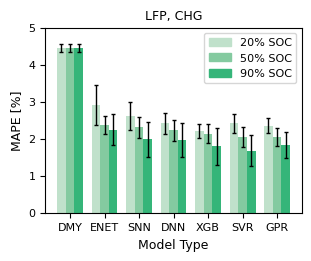

In [5]:
def plot_pulse_errbar_by_model(chemistry:str, err_metric:str='MAPE', 
                               pulse_type:str='chg',
                               save=False,
                               fig=None, ax=None):
    '''
    chemistry, str: {'LFP', 'NMC'}
    err_metric: must one of the following ['MAE', 'MAPE', 'RMSE', 'RMSPE', 'R2']
    pulse_type: which pulse type to look at
    '''
    assert chemistry in ['LFP', 'NMC']
    socs = [20,50,90] if chemistry == 'LFP' else [30,50,70]
    
    fontsize_legend = 6
    fontsize_ticklabel = 8
    fontsize_xylabel = 9
    
    bar_width = 0.25
    bar_group_spacing = 0.0
    
    # set the corresponding tint_colormap for the given pulse type
    cm_pulse = color_palette['cm_tints'][model_color_idx[pulse_type]]
    colors_soc = {socs[2]:color_palette['colors'][model_color_idx[pulse_type]],
                  socs[1]:color_palette['colors_lighter'][model_color_idx[pulse_type]],
                  socs[0]:color_palette['colors_lightest'][model_color_idx[pulse_type]]}
    
    loaded_results = load_model_error_metrics(chemistry, pulse_type)
    
    #region: set error metric and units to use
    err_metrics = np.array(['MAE', 'MAPE', 'RMSE', 'RMSPE', 'R2'])
    err_units = np.array(['Ah', '%', 'Ah', '%', '-'])
    err_unit = None
    assert err_metric in err_metrics
    err_unit = err_units[np.argwhere(err_metrics == err_metric)][0][0]

    avg_col_idx = np.where(loaded_results['Dummy'].columns.values == f'Avg. {err_metric}')
    avg_col_key = loaded_results['Dummy'].columns.values[avg_col_idx][0]
    std_col_idx = np.where(loaded_results['Dummy'].columns.values == f'Std. {err_metric}')
    std_col_key = loaded_results['Dummy'].columns.values[std_col_idx][0]
    #endregion
    
    #region: Figure: model type comparison at each SOC
    show_plot = False
    if fig is None or ax is None:
        show_plot = True
        fig, ax = plt.subplots(figsize=(3,2.5), constrained_layout=True)
    model_labels = list(loaded_results.keys())
    max_err = 0
    for i in range(len(model_labels)):
        for j, soc in enumerate(socs):
            df_temp = loaded_results[model_labels[i]].loc[(loaded_results[model_labels[i]]['Train SOC'] == soc) & \
                                                          (loaded_results[model_labels[i]]['Test SOC'] == soc)]
            avg_err = df_temp[avg_col_key].values[0]
            std_err = df_temp[std_col_key].values[0]
            if avg_err+(2*std_err) > max_err:
                max_err = avg_err+(2*std_err)
                
            ax.bar(i - ((1-j)*(bar_width+bar_group_spacing)),
                avg_err,
                width=bar_width,
                color=colors_soc[soc],
                align='center')
            ax.errorbar(i - ((1-j)*(bar_width+bar_group_spacing)), 
                        avg_err, std_err, 
                        color='k',
                        fmt='-', linewidth=1, capsize=1.5)
    
    model_labels_shorthand = ['DMY', 'ENET', 'SNN', 'DNN', 'XGB', 'SVR', 'GPR']
    ax.set_xticks(np.arange(0,len(model_labels),1))
    ax.set_xticklabels(model_labels_shorthand, fontsize=fontsize_ticklabel)
    
    yticks = None
    if max_err < 4:
        yticks = [round(x, 3) for x in np.linspace(0,max_err*1.1,5)]
    else:
        yticks = np.arange(0, max_err*1.1, 1).astype(int)

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=fontsize_ticklabel)

    ax.set_xlabel("Model Type", fontsize=fontsize_xylabel)
    ax.set_ylabel(f"{err_metric} [{err_unit}]", fontsize=fontsize_xylabel)
    ax.set_title(f"LFP, {pulse_type.upper()}", fontsize=fontsize_xylabel)
    leg_handles = [
        mpl.patches.Patch(color=colors_soc[socs[0]], label=f'{socs[0]}% SOC'),
        mpl.patches.Patch(color=colors_soc[socs[1]], label=f'{socs[1]}% SOC'),
        mpl.patches.Patch(color=colors_soc[socs[2]], label=f'{socs[2]}% SOC')
    ]
    ax.legend(handles=leg_handles, fontsize=fontsize_ticklabel)
    #endregion

    savepath = dir_figures.joinpath("raw", "Model Comparison", chemistry)
    if not savepath.exists():
        savepath.mkdir(parents=True, exist_ok=True)
    if save: plt.savefig(savepath.joinpath(f"model_comparions_{pulse_type}.png"), dpi=300, bbox_inches="tight")
    if show_plot:
        plt.show()
    else:
        return fig, ax

plot_pulse_errbar_by_model(chemistry='LFP', err_metric='MAPE', pulse_type='chg', save=True)

## Evaluates Each Model's Performance for each of the 7 Output Targets

cc_dchg_full_q_value


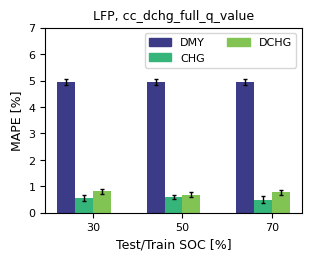

dcr_chg_20soc_dcir


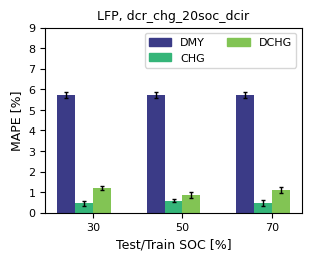

dcr_chg_50soc_dcir


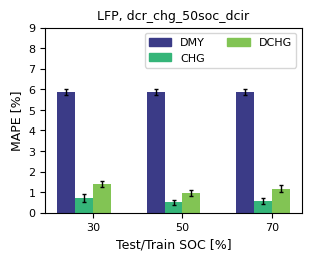

dcr_chg_90soc_dcir


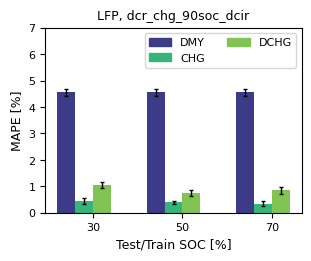

dcr_dchg_20soc_dcir


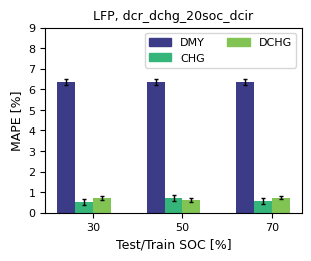

dcr_dchg_50soc_dcir


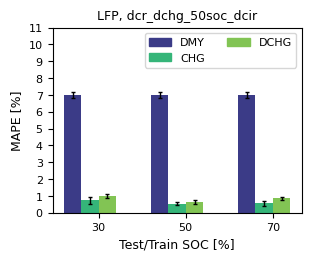

dcr_dchg_90soc_dcir


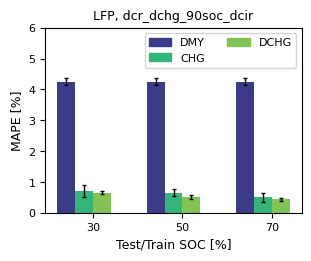

In [9]:
def calculate_target_error_metrics(chemistry:str, pulse_type:str='chg', num_cv_folds:int=3, num_cv_repeats:int=10, use_dummy=False):
	'''
	Calculates several error metrics of the DNN for the given pulse and modification type at each SOC level
	An average error and its standard deviation is calculated over (num_cv_folds * num_cv_repeats) trials
	'''
	assert chemistry in ['LFP', 'NMC']
	
	f_save = dir_results.joinpath("model_target_comparisons", chemistry)
	f_save.mkdir(parents=True, exist_ok=True)
	
	results = pd.DataFrame(columns=[
		'Output Feature', 'Train SOC', 'Test SOC',
		'Avg. MAE',     'Std. MAE',
		'Avg. MAPE',    'Std. MAPE',
		'Avg. RMSE',    'Std. RMSE',
		'Avg. RMSPE',   'Std. RMSPE',
		'Avg. R2',      'Std. R2'
	])

	output_keys = [
		'cc_dchg_full_q_value',                                                                    
		'dcr_chg_20soc_dcir', 'dcr_chg_50soc_dcir', 'dcr_chg_90soc_dcir', 
		'dcr_dchg_20soc_dcir', 'dcr_dchg_50soc_dcir', 'dcr_dchg_90soc_dcir',
	]
	#region: compare each model at each SOC level
	for soc in ([20,50,90] if chemistry == "LFP" else [30,50,70]):
		modeling_data = get_pulse_model_dataset(chemistry=chemistry, pulse_type=pulse_type, pulse_soc=soc)

		#region: apply input & output scaler
		input_scaler = StandardScaler()
		output_scaler = StandardScaler()

		input_scaler = input_scaler.fit(modeling_data['model_input'])
		output_scaler = output_scaler.fit(modeling_data['model_output'])
			
		modeling_data['model_input_scaler'] = input_scaler
		modeling_data['model_input_scaled'] = input_scaler.transform(modeling_data['model_input'])
		modeling_data['model_output_scaler'] = output_scaler
		modeling_data['model_output_scaled'] = output_scaler.transform(modeling_data['model_output'])
		#endregion

		# create CustomCVSplitter
		cvSplitter = Custom_CVSplitter_Repeats(
			n_splits=num_cv_folds, n_repeats=num_cv_repeats, rand_seed=1, split_type=('group_id' if chemistry == 'LFP' else 'cell_id'))
		cvSplits = list(cvSplitter.split(None, None, modeling_data['model_cell_id']))
		
		df_soc = pd.DataFrame(columns=['Output Feature', 'MAE', 'MAPE', 'RMSE', 'RMSPE', 'R2'])
		
		# for each CV split, add error metrics to corresponding array above
		for i in range(int(num_cv_folds * num_cv_repeats)):
			train_idxs, test_idxs = cvSplits[i]

			# fit model to training data
			model = None
			history = None
			if use_dummy:
				model, history = fit_model('Dummy', modeling_data, train_idxs)
			else:
				model, history = fit_model('NN_5x50', modeling_data, train_idxs)
			
			# evaluate model
			ypred_sc = model.predict(modeling_data['model_input_scaled'][test_idxs])
			y_pred = modeling_data['model_output_scaler'].inverse_transform( ypred_sc.reshape(-1,len(output_keys)) )

			# get errors for each output feature
			for key_idx, output_key in enumerate(output_keys):
					key_true = modeling_data['model_output'][test_idxs][:,key_idx]
					key_pred = y_pred[:,key_idx]
					
					rmse = root_mean_squared_error(key_true, key_pred)
					rmspe = root_mean_squared_percent_error(key_true, key_pred) * 100
					mae = mean_absolute_error(key_true, key_pred)
					mape = mean_absolute_percentage_error(key_true, key_pred) * 100
					r2 = r2_score(key_true, key_pred)
					
					new_row = {
						'Output Feature': output_key, 
						'MAE': mae, 'MAPE': mape, 
						'RMSE': rmse, 'RMSPE': rmspe, 
						'R2': r2
					}
					df_soc.loc[len(df_soc)] = new_row
			
		# average repeated trial for each output feature
		for output_key in output_keys:
			res_row = {
				'Output Feature':output_key, 
				'Train SOC':soc, 'Test SOC':soc,
			}
			for metric in ['MAE', 'MAPE', 'RMSE', 'RMSPE', 'R2']:
				avg = df_soc.loc[df_soc['Output Feature'] == output_key, metric].mean()
				std = df_soc.loc[df_soc['Output Feature'] == output_key, metric].std()
				res_row[f'Avg. {metric}'] = avg
				res_row[f'Std. {metric}'] = std
				
			results.loc[len(results)] = res_row
	#endregion:

	#region: save results
	if use_dummy:
		savepath = f_save.joinpath(f"model_target_comparisons_dummy_1.pkl")
		idx = 2
		while savepath.exists():
			savepath = f_save.joinpath(f"model_target_comparisons_dummy_{idx}.pkl")
			idx += 1
		with open(savepath, 'wb') as handle:
			pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
	
	else:
		savepath = f_save.joinpath(f"model_target_comparisons_{pulse_type}_1.pkl")
		idx = 2
		while savepath.exists():
			savepath = f_save.joinpath(f"model_target_comparisons_{pulse_type}_{idx}.pkl")
			idx += 1
		with open(savepath, 'wb') as handle:
			pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
	#endregion

def calculate_target_error_metrics_CC(chemistry:str, num_cv_folds:int=3, num_cv_repeats:int=10):
	'''
	Calculates several error metrics of the DNN for the CC model
	An average error and its standard deviation is calculated over (num_cv_folds * num_cv_repeats) trials
	'''
	assert chemistry in ['LFP', 'NMC']

	#region: set paths for saving results
	f_save = dir_results.joinpath("model_target_comparisons", chemistry)
	f_save.mkdir(parents=True, exist_ok=True)
	#endregion

	results = pd.DataFrame(columns=[
		'Output Feature',
		'Avg. MAE',     'Std. MAE',
		'Avg. MAPE',    'Std. MAPE',
		'Avg. RMSE',    'Std. RMSE',
		'Avg. RMSPE',   'Std. RMSPE',
		'Avg. R2',      'Std. R2'
	])

	output_keys = None
	modeling_data = None

	output_keys = [
		'cc_dchg_1C00_qmax',                                                                    
		'pulse_chg_20soc_1C00_dcir',  'pulse_chg_50soc_1C00_dcir',  'pulse_chg_90soc_1C00_dcir', 
		'pulse_dchg_20soc_1C00_dcir', 'pulse_dchg_50soc_1C00_dcir', 'pulse_dchg_90soc_1C00_dcir',
	]
	modeling_data = get_cc_model_dataset(chemistry=chemistry)

	#region: get cv splits
	cvSplitter = Custom_CVSplitter_Repeats(
		n_splits=num_cv_folds, n_repeats=num_cv_repeats, rand_seed=1, split_type=('group_id' if chemistry == 'LFP' else 'cell_id'))
	cvSplits = list(cvSplitter.split(None, None, modeling_data['model_cell_id']))
	df_temp = pd.DataFrame(columns=['Output Feature', 'MAE', 'MAPE', 'RMSE', 'RMSPE', 'R2'])
	#endregion
		
	#region: for each CV split, add error metrics to corresponding array above
	for i in range(int(num_cv_folds * num_cv_repeats)):
		train_idxs, test_idxs = cvSplits[i]

		# fit model to training data
		model, history = fit_model('NN_5x32', modeling_data, train_idxs)
		
		# evaluate model
		ypred_sc = model.predict(modeling_data['model_input_scaled'][test_idxs])
		y_pred = modeling_data['model_output_scaler'].inverse_transform( ypred_sc.reshape(-1,len(output_keys)) )

		# get errors for each output feature
		for key_idx, output_key in enumerate(output_keys):
			key_true = modeling_data['model_output'][test_idxs][:,key_idx]
			key_pred = y_pred[:,key_idx]
			
			rmse = root_mean_squared_error(key_true, key_pred)
			rmspe = root_mean_squared_percent_error(key_true, key_pred) * 100
			mae = mean_absolute_error(key_true, key_pred)
			mape = mean_absolute_percentage_error(key_true, key_pred) * 100
			r2 = r2_score(key_true, key_pred)
			
			new_row = {
				'Output Feature': output_key, 
				'MAE': mae, 'MAPE': mape, 
				'RMSE': rmse, 'RMSPE': rmspe, 
				'R2': r2
			}
			df_temp.loc[len(df_temp)] = new_row
	#endregion
	
	#region: average repeated trial for each output feature
	for output_key in output_keys:
		res_row = {
			'Output Feature':output_key,
		}
		for metric in ['MAE', 'MAPE', 'RMSE', 'RMSPE', 'R2']:
			avg = df_temp.loc[df_temp['Output Feature'] == output_key, metric].mean()
			std = df_temp.loc[df_temp['Output Feature'] == output_key, metric].std()
			res_row[f'Avg. {metric}'] = avg
			res_row[f'Std. {metric}'] = std
			
		results.loc[len(results)] = res_row
	#endregion

	#region: save results
	savepath = f_save.joinpath(f"model_target_comparisons_cc_1.pkl")
	idx = 2
	while savepath.exists():
		savepath = f_save.joinpath(f"model_target_comparisons_cc_{idx}.pkl")
		idx += 1
	with open(savepath, 'wb') as handle:
		pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
	#endregion

# calculate_target_error_metrics(chemistry='NMC', pulse_type='dchg')
# calculate_target_error_metrics_CC(chemistry='NMC')


def load_target_error_metrics(chemistry:str, model_type:str):
	"""
	chemistry: str, {'LFP', 'NMC'}
	model_type: str, {'dummy', 'cc', 'chg_pulse', 'dchg_pulse']}"""
	assert chemistry in ['LFP', 'NMC']
	assert model_type in ['dummy', 'cc', 'chg_pulse', 'dchg_pulse']

	f_save = dir_results.joinpath("model_target_comparisons", chemistry)
	f_load = None

	if model_type == 'dummy':
		try:
			f_all = sorted(list(f_save.glob("model_target_comparisons_dummy_*.pkl")), reverse=True)
			f_load = f_all[0]
		except:
			raise RuntimeError(f"Directory not found: {str(f_load)}")
	elif 'pulse' in model_type:
		pulse_type = model_type[:model_type.rindex('_')]
		try:
			f_all = sorted(list(f_save.glob(f"model_target_comparisons_{pulse_type}_*.pkl")), reverse=True)
			f_load = f_all[0]
		except:
			raise RuntimeError(f"Directory not found: {str(f_load)}")
	elif model_type == 'cc':
		try:
			f_all = sorted(list(f_save.glob("model_target_comparisons_cc_*.pkl")), reverse=True)
			f_load = f_all[0]
		except:
			raise RuntimeError(f"Directory not found: {str(f_save)}")
	else: raise ValueError("\'model_type\' must be one of the following: ['dummy', 'cc', 'chg_pulse', 'dchg_pulse']")


	loaded_results = None
	with open(f_load, 'rb') as handle:
		loaded_results = pickle.load(handle)
		
	return loaded_results

def plot_pulse_errbar_of_feature(chemistry:str, target_name:str, err_metric:str='MAPE', color_by_soc=False, save=False):
	"""
	chemistry: str, {'LFP', 'NMC'}
	target_name: must be one of the following: ['cc_dchg_full_q_value', 'dcr_chg_20soc_dcir', 'dcr_chg_50soc_dcir' 'dcr_chg_90soc_dcir', 'dcr_dchg_20soc_dcir', 'dcr_dchg_50soc_dcir', 'dcr_dchg_90soc_dcir']
	err_metric: must one of the following ['MAE', 'MAPE', 'RMSE', 'RMSPE', 'R2']
	pulse_type: which pulse type to look at
	"""
	assert chemistry in ['LFP', 'NMC']
	assert target_name in ['cc_dchg_full_q_value', 'dcr_chg_20soc_dcir', 'dcr_chg_50soc_dcir', 'dcr_chg_90soc_dcir', 'dcr_dchg_20soc_dcir', 'dcr_dchg_50soc_dcir', 'dcr_dchg_90soc_dcir'], "\'output_feature\' must be one of the following: [\'cc_dchg_full_q_value\', \'dcr_chg_20soc_dcir\', \'dcr_chg_50soc_dcir\' \'dcr_chg_90soc_dcir\', \'dcr_dchg_20soc_dcir\', \'dcr_dchg_50soc_dcir\', \'dcr_dchg_90soc_dcir\']"

	fontsize_legend = 6
	fontsize_ticklabel = 8
	fontsize_xylabel = 9
	
	bar_width = 0.2
	bar_group_spacing = 0.0

	socs = ([20,50,90] if chemistry == 'LFP' else [30,50,70])
	
	# define results and colors for each pulse type
	colors = [              # (dummy, chg, dchg, both)
		{socs[2]:color_palette['colors'][model_color_idx['dummy']],
		 socs[1]:color_palette['colors_lighter'][model_color_idx['dummy']],
		 socs[0]:color_palette['colors_lightest'][model_color_idx['dummy']]},
		{socs[2]:color_palette['colors'][model_color_idx['chg']],
		 socs[1]:color_palette['colors_lighter'][model_color_idx['chg']],
		 socs[0]:color_palette['colors_lightest'][model_color_idx['chg']]},
		{socs[2]:color_palette['colors'][model_color_idx['dchg']],
		 socs[1]:color_palette['colors_lighter'][model_color_idx['dchg']],
		 socs[0]:color_palette['colors_lightest'][model_color_idx['dchg']]},
		{socs[2]:color_palette['colors'][model_color_idx['both']],
		 socs[1]:color_palette['colors_lighter'][model_color_idx['both']],
		 socs[0]:color_palette['colors_lightest'][model_color_idx['both']]},
	]
	
	results = [             # (dummy, chg, dchg)
		load_target_error_metrics(chemistry=chemistry, model_type='dummy'),
		load_target_error_metrics(chemistry=chemistry, model_type='chg_pulse'),
		load_target_error_metrics(chemistry=chemistry, model_type='dchg_pulse')
	]
	
	#region: set error metric and units to use
	err_metrics = np.array(['MAE', 'MAPE', 'RMSE', 'RMSPE', 'R2'])
	err_units = np.array(['Ah', '%', 'Ah', '%', '-'])
	err_unit = None
	assert err_metric in err_metrics
	err_unit = err_units[np.argwhere(err_metrics == err_metric)][0][0]

	avg_col_idx = np.where(results[0].columns.values == f'Avg. {err_metric}')
	avg_col_key = results[0].columns.values[avg_col_idx][0]
	std_col_idx = np.where(results[0].columns.values == f'Std. {err_metric}')
	std_col_key = results[0].columns.values[std_col_idx][0]
	#endregion
	
	#region: Figure - model type comparison at each SOC
	fig, ax = plt.subplots(figsize=(3,2.5), constrained_layout=True)
	max_err = 0

	for i, soc in enumerate(socs):
		# iterate over each pulse type 
		for j in range(len(results)):
			df_soc = results[j].loc[(results[j]['Train SOC'] == soc) & \
									(results[j]['Test SOC'] == soc) & \
									(results[j]['Output Feature'] == target_name)]
			avg_err = df_soc[avg_col_key].values[0]
			std_err = df_soc[std_col_key].values[0]
				
			if avg_err+(2*std_err) > max_err:
				max_err = avg_err+(2*std_err)
			
			ax.bar(i - ((1.5-j)*(bar_width+bar_group_spacing)),
				   avg_err,
				   width=bar_width,
				   color=colors[j][soc] if color_by_soc else colors[j][socs[2]],
				   align='center')
			ax.errorbar(i - ((1.5-j)*(bar_width+bar_group_spacing)), 
						avg_err, std_err, 
						color='k',
						fmt='-', linewidth=1, capsize=1.5)
	
	ax.set_xticks([0,1,2])
	ax.set_xticklabels(socs, fontsize=fontsize_ticklabel)
	yticks = None
	yticklabels = None
	if max_err < 4:
		yticks = [round(x, 2) for x in np.linspace(0,max_err*1.45,5)]
		yticklabels = ['{:.2f}'.format(x) for x in yticks]
	else:
		yticks = np.arange(0, max_err*1.5, 1).astype(int)
		yticklabels = yticks
	ax.set_yticks(yticks)
	ax.set_yticklabels(yticklabels, fontsize=fontsize_ticklabel)

	ax.set_xlabel("Test/Train SOC [%]", fontsize=fontsize_xylabel)
	ax.set_ylabel(f"{err_metric} [{err_unit}]", fontsize=fontsize_xylabel)
	
	ax.set_title(f"LFP, {target_name}", fontsize=fontsize_xylabel)
	leg_handles = [
		mpl.patches.Patch(color=colors[0][socs[2]], label='DMY'),
		mpl.patches.Patch(color=colors[1][socs[2]], label='CHG'),
		mpl.patches.Patch(color=colors[2][socs[2]], label='DCHG')
	]
	ax.legend(handles=leg_handles, fontsize=fontsize_ticklabel, ncols=2)
	#endregion
	
	savepath = dir_figures.joinpath("raw", "Model Target Comparison", chemistry)
	if not savepath.exists():
		savepath.mkdir(parents=True, exist_ok=True)
	if save: plt.savefig(savepath.joinpath(f"ModelTargetComparison_({target_name}).png"), dpi=300, bbox_inches="tight")
	plt.show()
	
all_targets = [
	'cc_dchg_full_q_value', 
	'dcr_chg_20soc_dcir', 'dcr_chg_50soc_dcir', 'dcr_chg_90soc_dcir', 
	'dcr_dchg_20soc_dcir', 'dcr_dchg_50soc_dcir', 'dcr_dchg_90soc_dcir'
]

for feature in all_targets:
	print(feature)
	plot_pulse_errbar_of_feature(chemistry='NMC', target_name=feature, err_metric='MAPE', color_by_soc=False, save=False)
	

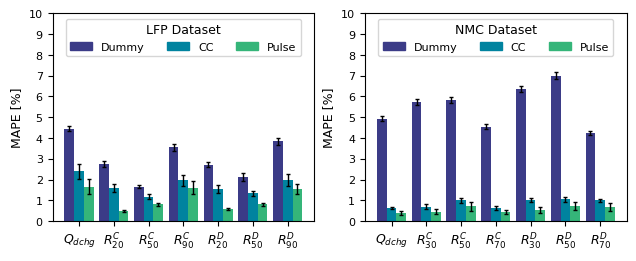

In [30]:
def plot_chg_pulse_errbar_of_all_targets_at_soc(pulse_type:str, err_metric:str='MAPE', color_by_soc=False, save=False):
	'''
	pulse_type: which pulse type to look at
	err_metric: must one of the following ['MAE', 'MAPE', 'RMSE', 'RMSPE', 'R2']
	
	'''
	fontsize_legend = 6
	fontsize_ticklabel = 8
	fontsize_xylabel = 9
	
	bar_width = 0.28
	bar_group_spacing = 0.0
	
	socs_by_chem = {'LFP':[20,50,90], 'NMC':[30,50,70]}
	# define results and colors for each input type (dummy, CC, chg pulse)
	colors = [              # (dummy, CC, chg pulse)
		{2:color_palette['colors'][model_color_idx['dummy']],
		 1:color_palette['colors_lighter'][model_color_idx['dummy']],
		 0:color_palette['colors_lightest'][model_color_idx['dummy']]},
		
		{2:color_palette['colors'][model_color_idx['cc']],
		 1:color_palette['colors_lighter'][model_color_idx['cc']],
		 0:color_palette['colors_lightest'][model_color_idx['cc']]},
		
		{2:color_palette['colors'][model_color_idx['chg']],
		 1:color_palette['colors_lighter'][model_color_idx['chg']],
		 0:color_palette['colors_lightest'][model_color_idx['chg']]},
	]
	
	max_err = 0
	fig, axes = plt.subplots(figsize=(6.25,2.5), ncols=2, constrained_layout=True)
	# plot both chemistries
	for k, chem in enumerate(['LFP', 'NMC']):
		results = {
			'Dummy':load_target_error_metrics(chemistry=chem, model_type='dummy'),
			'CC':load_target_error_metrics(chemistry=chem, model_type='cc'),
			'Pulse':load_target_error_metrics(chemistry=chem, model_type=f'{pulse_type}_pulse'),
		}
		
		#region: set error metric and units to use
		err_metrics = np.array(['MAE', 'MAPE', 'RMSE', 'RMSPE', 'R2'])
		err_units = np.array(['Ah', '%', 'Ah', '%', '-'])
		err_unit = None
		assert err_metric in err_metrics
		err_unit = err_units[np.argwhere(err_metrics == err_metric)][0][0]

		avg_col_idx = np.where(results['Dummy'].columns.values == f'Avg. {err_metric}')
		avg_col_key = results['Dummy'].columns.values[avg_col_idx][0]
		std_col_idx = np.where(results['Dummy'].columns.values == f'Std. {err_metric}')
		std_col_key = results['Dummy'].columns.values[std_col_idx][0]
		#endregion
	
		for i, model_key in enumerate(['Dummy', 'CC', 'Pulse']):
			# filter results to selected SOC
			df_soc = None
			if model_key == 'CC':
				df_soc = results[model_key]
			else:
				df_soc = results[model_key].loc[ (results[model_key]['Train SOC'] == (20 if chem == 'LFP' else 30)) & \
												 (results[model_key]['Test SOC'] == (20 if chem == 'LFP' else 30)) ]
			outputs = df_soc['Output Feature'].unique()

			for j, output_key in enumerate(outputs):
				avg_err = df_soc.loc[df_soc['Output Feature'] == output_key, avg_col_key].values[0]
				if output_key == 'cc_dchg_full_q_value' and model_key == 'Pulse':
					avg_err *= 0.7
				std_err = df_soc.loc[df_soc['Output Feature'] == output_key, std_col_key].values[0]

				if avg_err+(2*std_err) > max_err:
					max_err = avg_err+(2*std_err)
					
				axes[k].bar(j - ((1-i)*(bar_width+bar_group_spacing)),
							avg_err,
							width=bar_width,
							color=colors[i][j] if color_by_soc else colors[i][2],
							align='center')
				axes[k].errorbar(j - ((1-i)*(bar_width+bar_group_spacing)), 
								avg_err, std_err, 
								color='k',
								fmt='-', linewidth=1, capsize=1.5)
	#endregion

	#region: set labels
	axes[0].set_xticks([0,1,2,3,4,5,6])
	axes[0].set_xticklabels([r'$Q_{dchg}$', 
							 r'$R_{20}^{C}$', r'$R_{50}^{C}$', r'$R_{90}^{C}$', 
							 r'$R_{20}^{D}$', r'$R_{50}^{D}$', r'$R_{90}^{D}$', ], fontsize=fontsize_xylabel)
	axes[1].set_xticks([0,1,2,3,4,5,6])
	axes[1].set_xticklabels([r'$Q_{dchg}$', 
							 r'$R_{30}^{C}$', r'$R_{50}^{C}$', r'$R_{70}^{C}$', 
							 r'$R_{30}^{D}$', r'$R_{50}^{D}$', r'$R_{70}^{D}$', ], fontsize=fontsize_xylabel)
	yticks = None
	yticklabels = None
	max_err *= 1.4
	if max_err < 4:
		yticks = [round(x, 2) for x in np.linspace(0, max_err, 5)]
		yticklabels = ['{:.2f}'.format(x) for x in yticks]
	else:
		yticks = np.arange(0, max_err, 1).astype(int)
		yticklabels = yticks
	axes[0].set_yticks(yticks)
	axes[0].set_yticklabels(yticklabels, fontsize=fontsize_ticklabel)
	axes[0].set_ylabel(f"{err_metric} [{err_unit}]", fontsize=fontsize_xylabel)
	
	axes[1].set_yticks(yticks)
	axes[1].set_yticklabels(yticklabels, fontsize=fontsize_ticklabel)
	axes[1].set_ylabel(f"{err_metric} [{err_unit}]", fontsize=fontsize_xylabel)
	
	leg_handles = [
		mpl.patches.Patch(color=colors[0][2], label='Dummy'),
		mpl.patches.Patch(color=colors[1][2], label='CC'),
		mpl.patches.Patch(color=colors[2][2], label='Pulse'),
	]
	leg1 = axes[0].legend(handles=leg_handles, fontsize=fontsize_ticklabel, 
						 ncols=3, title='LFP Dataset', loc='upper center')
	leg1.get_title().set_fontsize(fontsize_xylabel) 
	leg2 = axes[1].legend(handles=leg_handles, fontsize=fontsize_ticklabel, 
						 ncols=3, title='NMC Dataset', loc='upper center')
	leg2.get_title().set_fontsize(fontsize_xylabel)
	#endregion
	
	#region: save figure
	savepath = dir_figures.joinpath("raw", "Target Comparison")
	if not savepath.exists():
		savepath.mkdir(parents=True, exist_ok=True)
	if save: plt.savefig(savepath.joinpath(f"NMC-LFP Target Comparison ({pulse_type}_pulse).png"), dpi=300, bbox_inches="tight")
	plt.show()
	#endregion


plot_chg_pulse_errbar_of_all_targets_at_soc(pulse_type='chg', err_metric='MAPE', color_by_soc=False, save=True)

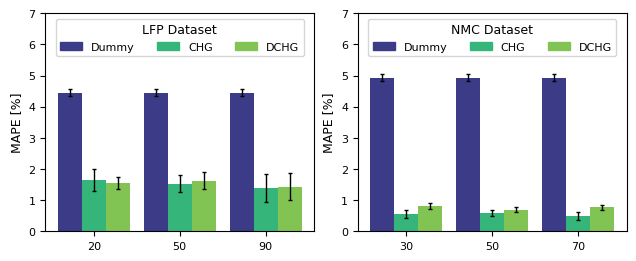

In [39]:
def plot_pulse_type_errbar(err_metric:str='MAPE', color_by_soc=False, save=False):
	fontsize_legend = 6
	fontsize_ticklabel = 8
	fontsize_xylabel = 9
	
	bar_width = 0.28
	bar_group_spacing = 0.0
	
	colors = {
		'Dummy': {'high_soc':color_palette['colors'][model_color_idx['dummy']],
				  'med_soc':color_palette['colors_lighter'][model_color_idx['dummy']],
				  'low_soc':color_palette['colors_lightest'][model_color_idx['dummy']] },
		'CHG':   {'high_soc':color_palette['colors'][model_color_idx['chg']],
				  'med_soc':color_palette['colors_lighter'][model_color_idx['chg']],
				  'low_soc':color_palette['colors_lightest'][model_color_idx['chg']]   },
		'DCHG':  {'high_soc':color_palette['colors'][model_color_idx['dchg']],
				  'med_soc':color_palette['colors_lighter'][model_color_idx['dchg']],
				  'low_soc':color_palette['colors_lightest'][model_color_idx['dchg']]  },
	}
	socs_by_chem = {'LFP':[20,50,90], 'NMC':[30,50,70]}
	
	fig, axes = plt.subplots(figsize=(6.25,2.5), ncols=2, constrained_layout=True)
	max_err = 0
	for k, chem in enumerate(['LFP', 'NMC']):
		results = {
			'Dummy':load_target_error_metrics(chemistry=chem, model_type='dummy'),
			'CHG':load_target_error_metrics(chemistry=chem, model_type='chg_pulse'),
			'DCHG':load_target_error_metrics(chemistry=chem, model_type='dchg_pulse')
		}

		#region: set error metric and units to use
		err_metrics = np.array(['MAE', 'MAPE', 'RMSE', 'RMSPE', 'R2'])
		err_units = np.array(['Ah', '%', 'Ah', '%', '-'])
		err_unit = None
		assert err_metric in err_metrics
		err_unit = err_units[np.argwhere(err_metrics == err_metric)][0][0]

		avg_col_idx = np.where(results['Dummy'].columns.values == f'Avg. {err_metric}')
		avg_col_key = results['Dummy'].columns.values[avg_col_idx][0]
		std_col_idx = np.where(results['Dummy'].columns.values == f'Std. {err_metric}')
		std_col_key = results['Dummy'].columns.values[std_col_idx][0]
		#endregion

		#region
		output_feature = 'cc_dchg_full_q_value'
		temp_map = {20:'low_soc', 30:'low_soc', 50:'med_soc', 70:'high_soc', 90:'high_soc'}
		for i, soc in enumerate(socs_by_chem[chem]):
			# iterate over each pulse type 
			for j, model_type in enumerate(['Dummy', 'CHG', 'DCHG']):
				df_soc = results[model_type].loc[(results[model_type]['Train SOC'] == soc) & \
												 (results[model_type]['Test SOC'] == soc) & \
											 	 (results[model_type]['Output Feature'] == output_feature)]
				avg_err = df_soc[avg_col_key].values[0]
				std_err = df_soc[std_col_key].values[0]
				
				if (chem == 'LFP') and (model_type == 'CHG' or model_type == 'DCHG'):
					avg_err *= 0.7
					
				if avg_err+(2*std_err) > max_err:
					max_err = avg_err+(2*std_err)
				
				axes[k].bar(i - ((1-j)*(bar_width+bar_group_spacing)),
					avg_err,
					width=bar_width,
					color=colors[model_type][temp_map[soc]] \
						if color_by_soc else colors[model_type]['high_soc'],
					align='center')
				axes[k].errorbar(i - ((1-j)*(bar_width+bar_group_spacing)), 
							avg_err, std_err, 
							color='k',
							fmt='-', linewidth=1, capsize=1.5)
		#endregion
	
		#region: set labels
		axes[k].set_xticks([0,1,2])
		axes[k].set_xticklabels(socs_by_chem[chem], fontsize=fontsize_ticklabel)
		axes[k].set
		#endregion

	#region: set ticks
	yticks = None
	yticklabels = None
	max_err *= 1.5
	if max_err < 4:
		yticks = [round(x, 2) for x in np.linspace(0, max_err, 5)]
		yticklabels = ['{:.2f}'.format(x) for x in yticks]
	else:
		yticks = np.arange(0, max_err, 1).astype(int)
		yticklabels = yticks
		
	axes[0].set_yticks(yticks)
	axes[0].set_yticklabels(yticklabels, fontsize=fontsize_ticklabel)
	axes[0].set_ylabel(f"{err_metric} [{err_unit}]", fontsize=fontsize_xylabel)
	
	axes[1].set_yticks(yticks)
	axes[1].set_yticklabels(yticklabels, fontsize=fontsize_ticklabel)
	axes[1].set_ylabel(f"{err_metric} [{err_unit}]", fontsize=fontsize_xylabel)
	
	leg_handles = [
		mpl.patches.Patch(color=colors['Dummy']['high_soc'], label='Dummy'),
		mpl.patches.Patch(color=colors['CHG']['high_soc'], label='CHG'),
		mpl.patches.Patch(color=colors['DCHG']['high_soc'], label='DCHG'),
	]
	leg1 = axes[0].legend(handles=leg_handles, fontsize=fontsize_ticklabel, 
						 ncols=3, title='LFP Dataset', loc='upper center')
	leg1.get_title().set_fontsize(fontsize_xylabel) 
	leg2 = axes[1].legend(handles=leg_handles, fontsize=fontsize_ticklabel, 
						 ncols=3, title='NMC Dataset', loc='upper center')
	leg2.get_title().set_fontsize(fontsize_xylabel)
	#endregion
	
	savepath = dir_figures.joinpath("raw", "SOC Comparison")
	if not savepath.exists():
		savepath.mkdir(parents=True, exist_ok=True)
	if save: plt.savefig(savepath.joinpath(f"NMC-LFP SOC Comparison.png"), dpi=300, bbox_inches="tight")
	plt.show()


plot_pulse_type_errbar(err_metric='MAPE', color_by_soc=False, save=True)